<h1>SIT307 Group Assignment 1 notebook</h1>

<h3>Group 3</h3>
<p>By:<br>
    Aaron Norwood,218330434<br>
    Joshua Anthony, 219466473<br>
    Roger Middenway, 217602784<br>
    David Adams, 216110104<br>
    Linden Hutchinson, 218384326<br>
    Dale Orders, 219106283

# Imported libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy import stats
import plotly.express as px
%matplotlib inline

<h3> Read in the data, store if dataframe

In [2]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

<h4>Tidying

In [3]:
##convert gender to lowercase
df['gender'] = df['gender'].apply(lambda x: x.lower())

# print(len(df[df['gender'] == 'other']))
## drop the one row that has "other" gender to keep things simple
df.drop(index=df[df['gender'] == 'other'].index, inplace=True)

# replace gender with binary values
df['gender'] = df['gender'].str.lower().map({'male': 1, 'female': 0})

# replace marital status with binary values
df['ever_married'] = df['ever_married'].str.lower().map({'yes': 1, 'no': 0})

##convert work_type to lowercase ensure consistent spacing 
df['work_type'] = df['work_type'].apply(lambda x: x.lower().replace('_','-'))

##convert residence_type to lowercase
df.rename(columns={'Residence_type':'residence_type'}, inplace=True)
df['residence_type'] = df['residence_type'].apply(lambda x: x.lower())

##convert smoking_status to lowercase ensure consistent spacing 
df['smoking_status'] = df['smoking_status'].apply(lambda x: x.lower().replace(' ', '-'))

## round off age
df['age'] = df['age'].apply(lambda x : round(x))

# cap BMI outliers to a maximum of 60 
df['bmi'] = df['bmi'].apply(lambda bmi_value: bmi_value if 12 < bmi_value < 60 else np.nan)

<h4>Imputing

In [4]:
m_df = df[df['gender'] == 1]
f_df = df[df['gender'] == 0]

m_bmi_avg = m_df.groupby('age')['bmi'].mean()
f_bmi_avg = f_df.groupby('age')['bmi'].mean()
##round to one to fit with other bmi values
m_bmi_avg = round(m_bmi_avg,1)
f_bmi_avg = round(f_bmi_avg,1)

missing_vals = df[df.isnull().any(axis = 1)]

for index, row in missing_vals.iterrows():
    if row['gender'] == 1:
        df.loc[index,['bmi']] = m_bmi_avg[row['age']]
    else:
        df.loc[index,['bmi']] = f_bmi_avg[row['age']]

<h4>Binning

In [5]:
# implement age bins
df['age_bin'] = pd.qcut(df['age'], q = 10, precision=1)

# implement glucose bins
df['avg_glucose_level_bin'] = pd.qcut(df['avg_glucose_level'], q=10, precision=1)

# implement bmi bins
df['bmi_bin'] = pd.qcut(df['bmi'], q=10, precision=1)

<h4>Mapping

In [6]:
work_type_map = {
    'private':0,
    'self-employed':1,
    'govt-job':2,
    'children':3,
    'never-worked':4
}
residence_type_map = {
    'urban':0,
    'rural':1
}
smoking_status_map = {
    'formerly-smoked':0,
    'never-smoked':1,
    'smokes':2,
    'unknown':3
}

df['work_type'] = df['work_type'].map(work_type_map)
df['residence_type'] = df['residence_type'].map(residence_type_map)
df['smoking_status'] = df['smoking_status'].map(smoking_status_map)

In [7]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_bin,avg_glucose_level_bin,bmi_bin
0,9046,1,67,0,1,1,0,0,228.69,36.6,0,1,"(65.0, 75.0]","(192.2, 271.7]","(34.2, 38.6]"
1,51676,0,61,0,0,1,1,1,202.21,29.1,1,1,"(57.0, 65.0]","(192.2, 271.7]","(28.2, 29.9]"
2,31112,1,80,0,1,1,0,1,105.92,32.5,1,1,"(75.0, 82.0]","(98.9, 108.5]","(31.8, 34.2]"
3,60182,0,49,0,0,1,0,0,171.23,34.4,2,1,"(45.0, 51.0]","(124.1, 192.2]","(34.2, 38.6]"
4,1665,0,79,1,0,1,1,1,174.12,24.0,1,1,"(75.0, 82.0]","(124.1, 192.2]","(22.6, 24.7]"


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf
from tensorflow import keras

In [9]:
train_columns = ['gender','hypertension','heart_disease','smoking_status','age','avg_glucose_level','bmi']

y = df['stroke']
X = df[train_columns]
# X = pd.get_dummies(df, columns=['age_bin','avg_glucose_level_bin','bmi_bin'])

In [10]:
counter = Counter(y)
print('Before',counter)
# oversampling the train dataset using SMOTE
X_smote, y_smote = SMOTE().fit_resample(X, y)

counter = Counter(y_smote)
print('After',counter)

Before Counter({0: 4860, 1: 249})
After Counter({1: 4860, 0: 4860})


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3)

tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
model = keras.Sequential([
    keras.layers.Dense(64,input_shape=(X_smote.shape[1],),activation='relu'),
    keras.layers.Dense(units=192, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=2, activation='softmax')
])
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
historico = model.fit(X_train,y_train,epochs = 200,validation_split = 0.1,verbose = 0)

In [14]:
val=historico.history

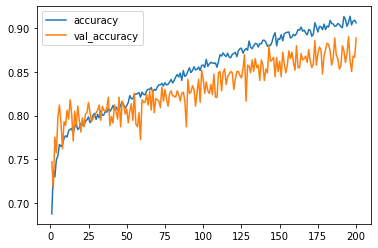

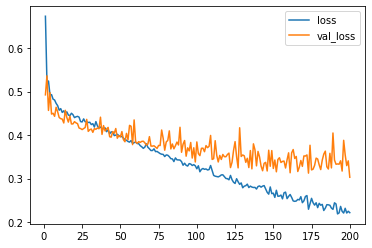

In [15]:
def plot_metric(model_history, metric):
    plt.plot(np.arange(1,len(model_history[metric])+1),model_history[metric],label=metric)
    val_metric = f"val_{metric}"
    plt.plot(np.arange(1,len(model_history[val_metric])+1),model_history[val_metric],label=val_metric)
    plt.legend()
    plt.show()
    
plot_metric(val,'accuracy')
plot_metric(val,'loss')

In [16]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [18]:

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

cm = confusion_matrix(y_true= y_test, y_pred=y_pred_bool)
plot_confusion_matrix(cm=cm, classes = ['Non Stroke','Stroke'])
plt.plot()

46/46 [==============================] - 0s 609us/step
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1479
           1       0.85      0.93      0.89      1437

    accuracy                           0.88      2916
   macro avg       0.89      0.88      0.88      2916
weighted avg       0.89      0.88      0.88      2916

